# Program for creating neural networks for the Alcohol consumption dataset

#### Intent of the program
The program attempts to create an optimal neural network for the drug consumption dataset. 

The details of the dataset can be found here "UCI Machine Learning Repository: Drug consumption (quantified) Data Set" https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

NOTE: The code only supports .csv and the file from the UCI first needs to be converted from .data to .csv. The .data file only contains the rows and not the headers and hence the column names must be added to the .data file and then convert the file to .csv.

## Environment setup

### Importing libraries

In [1]:
# Importing the required libraries
import warnings
import importlib
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from sklearn.utils import resample, class_weight
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

# Ignoring warnings for clean output display
warnings.filterwarnings("ignore")
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### Declaring variables required for running the program

In [2]:
# Variable declaration

# Variable holding the default number of neurons
neurons_no = 5

# Declaring boolean variables to  help with selecting the balancing technique
"""
Technique 1: Original dataset (No data sample and class balance) ==> is_resampled = False AND is_smote = False 
              AND is_class_balanced = False
Technique 2: Data samples imbalanced and class weight balanced ==> is_resampled = False AND is_smote = False 
              AND is_class_balanced = True
Technique 3: Data samples balanced using replication without class weight balance ==> is_resampled = True AND is_smote = False 
              AND is_class_balanced = False
Technique 4: Data samples balanced using replication with class weight balance ==> is_resampled = True AND is_smote = False 
              AND is_class_balanced = False
Technique 5: Data samples balanced using SMOTE technique without class weight balance ==> is_resampled = False AND 
              is_smote = True AND is_class_balanced = False
Technique 6: Data samples balanced using SMOTE technique with class weight balance ==> is_resampled = False AND 
              is_smote = True AND is_class_balanced = True
By default all values are set to False. Based the chosen technique make necessary changes to the boolean variables.
IMPORTANT NOTE: Ensure to setup either one of "is_resampled" or "is_smote" as "True".
"""
is_resampled = False
is_smote = False
is_class_balanced = False

# Condition to check the setup
if(is_resampled == True and is_smote == True):
    print("Both is_resampled and is_smote cannot be set as True. Please update the either one to False.")
    sys.exit("Do not execute the cells below.")

# Dictionaries for categorical variables
dict_Age = {
    -0.95197: 'AG1',
    -0.07854: 'AG2',
    0.49788: 'AG3',
    1.09449: 'AG4',
    1.82213: 'AG5',
    2.59171: 'AG6'
}

dict_Education = {
    -2.43591: 'EDU1',
    -1.7379: 'EDU2',
    -1.43719: 'EDU3',
    -1.22751: 'EDU4',
    -0.61113: 'EDU5',
    -0.05921: 'EDU6',
    0.45468: 'EDU7',
    1.16365: 'EDU8',
    1.98437: 'EDU9'
}

dict_Gender = {
    0.48246: 'F',
    -0.48246: 'M'
}

dict_Country = {
    -0.09765: 'AU',
    0.24923: 'CA',
    -0.46841: 'NZ',
    0.21128: 'ROI',
    0.96082: 'UK',
    -0.57009: 'USA',
    -0.28519: 'Other'
}

dict_Ethinicity = {
    -0.50212: 'ETH1',
    -1.10702: 'ETH2',
    1.90725: 'ETH3',
    0.126: 'ETH4',
    -0.22166: 'ETH5',
    -0.31685: 'ETH6',
    0.1144: 'ETH7'
}

# Dictionary for the target attributes classes
dict_user = {
    'CL0': 'N',
    'CL1': 'N',
    'CL2': 'N',
    'CL3': 'N',
    'CL4': 'N',
    'CL5': 'N',
    'CL6': 'Y'
}

# Dictionary for the attributes that need to be mapped
cat_list_dict = {
    'Age': dict_Age,
    'Education': dict_Education,
    'Gender': dict_Gender,
    'Country': dict_Country,
    'Ethinicity': dict_Ethinicity,
    'Alcohol': dict_user
}


### Defining functions required for running the program

In [3]:
# Function to convert categorical features to one-hot encoding
def OneHotEncoding(df, column_name, prefix_name):
    y = pd.get_dummies(df[column_name], prefix=prefix_name)
    return y

# Function to convert target variables categories to '0' and '1'
def fun(e):
    if e == 'Y':
        return 1
    else:
        return 0

# Creating a model to find the best optimizer
def create_model_opt(optimizer='adam'):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate for Adam
def create_model_Adam(learn_rate=0.01):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = Adam(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate for Adagrad
def create_model_Adagrad(learn_rate=0.01):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = Adagrad(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate for Adadelta
def create_model_Adadelta(learn_rate=0.01):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = Adadelta(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate for Adamax
def create_model_Adamax(learn_rate=0.01):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = Adamax(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate for Nadam
def create_model_Nadam(learn_rate=0.01):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = Nadam(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate and momentum for SDG
def create_model_SDG(learn_rate=0.01, momentum=0.0):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = SDG(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Creating a model to find the best learning rate and momentum for RMSprop
def create_model_RMSprop(learn_rate=0.01, momentum=0.0):
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_no, input_dim=len(
        feature_list), activation='sigmoid'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    optimizer = RMSprop(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model

# Function to generate strip plots
def plot_stripplot(data, cat_var):
    fig, ax = plt.subplots()
    sns.stripplot(x=data['Alcoholenc'], y=data[cat_var], ax=ax)
    plt.suptitle("Strip plot for {}".format(cat_var), fontsize=14,
                 fontname="Times New Roman", fontweight="bold");

# Function to print the best learning rate and momentum
def printLRandMomentum(best_optimizer, best_lr, best_mom):
    if best_optimizer in ('SGD', 'RMSprop'):
        print("Selected Learning rate: {}".format(best_lr))
        print("Selected Momentum: {}".format(best_mom))
    else:
        best_lr = grid_result_lr.best_params_['learn_rate']
        print("Selected Learning rate: {}".format(best_lr))

# Function to convert string to a class
def stringToClass(className):
    _class = getattr(importlib.import_module(
        "tensorflow.keras.optimizers"), className)
    return _class


## Analysing the original data

In [4]:
# Importing the data set from the csv file to a dataframe
data = pd.read_csv('drug_consumption.csv')

# Dropping the ID and drug columns other than 'Alcohol'
column_list = [
    'ID',
    # 'Age',
    # 'Gender',
    # 'Education',
    # 'Country',
    # 'Ethinicity',
    # 'Nscore',
    # 'Escore',
    # 'Oscore',
    # 'Ascore',
    # 'Cscore',
    # 'Impulsive',
    # 'SS',
    # 'Alcohol',
    'Amphet',
    'Amyl',
    'Benzos',
    'Caff',
    'Cannabis',
    'Choc',
    'Coke',
    'Crack',
    'Ecstasy',
    'Heroin',
    'Ketamine',
    'Legalh',
    'LSD',
    'Meth',
    'Mushrooms',
    'Nicotine',
    'Semer',
    'VSA'
]
data = data.drop(column_list, axis=1)

# Storing the target attribute
column_name = 'Alcohol'

# Converting the target attribute values into categorical data
data[column_name] = pd.Categorical(data[column_name])

print("\033[1mThe original data set:\033[0m")
data


The original data set:


,Age,Gender,Education,Country,Ethinicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,CL5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,CL5
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,CL4
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,CL5


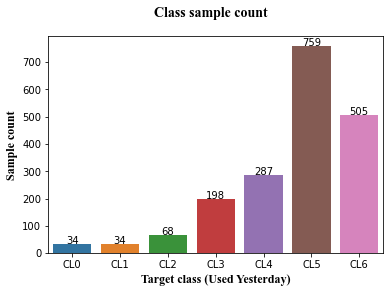

In [5]:
# Plotting the sample count in each class
ax = sns.countplot(data['Alcohol'])
for rect in ax.patches:
    ax.annotate(rect.get_height(), (rect.get_x() +
                rect.get_width()/2, rect.get_height() + 0.75), ha='center')
plt.suptitle("Class sample count", fontsize=14,
             fontname="Times New Roman", fontweight="bold");
plt.xlabel('Target class (Used Yesterday)', fontsize=12,
           fontname="Times New Roman", fontweight="bold");
plt.ylabel('Sample count', fontsize=12,
           fontname="Times New Roman", fontweight="bold");


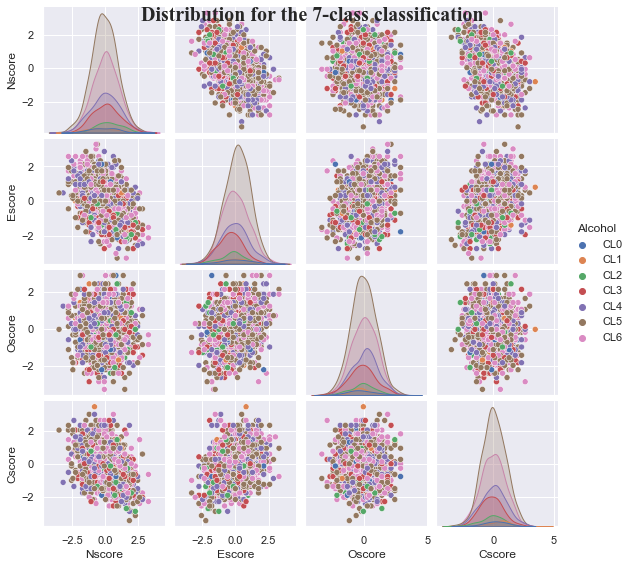

In [6]:
# Plotting the distribution for the 7-class classification
col_to_plot = data.columns[5:].tolist()
col_to_plot = [i for i in col_to_plot if i in (
    'Nscore', 'Escore', 'Cscore', 'Oscore', 'Alcohol')]
sns.set()
sns.pairplot(data[col_to_plot], hue=column_name, height=2)
plt.suptitle("Distribution for the 7-class classification",
             fontsize=20, fontname="Times New Roman", fontweight="bold");


## Shift to binary classification and Feature Engineering

In [7]:
# Mapping all the categorical attributes and target attribute to readable labels
# This code also converts the 7-class classification to a binary classification based on the values defined in the "dict_user" dictionary
for cat in cat_list_dict.keys():
    data[cat] = data.apply(
        lambda row: cat_list_dict.get(cat).get(row[cat]), axis=1)


### Strip plot for feature engineering categorical variables

In [8]:
# Adding an Alcoholenc column to hold the encoded values
le = preprocessing.LabelEncoder()
le.fit(data['Alcohol'])
data['Alcoholenc'] = le.transform(data['Alcohol'])


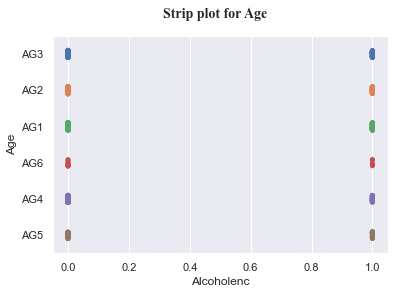

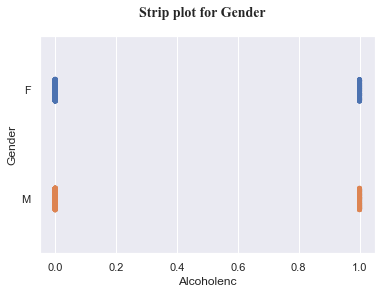

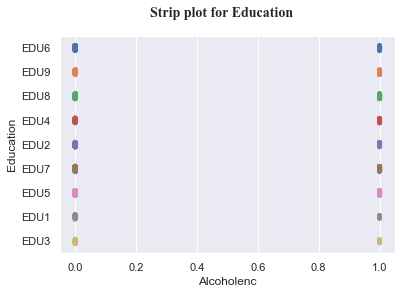

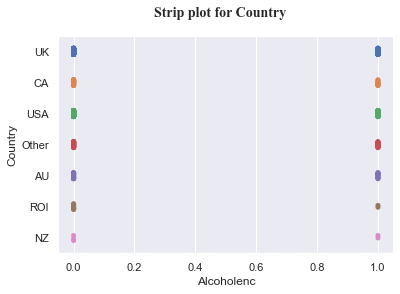

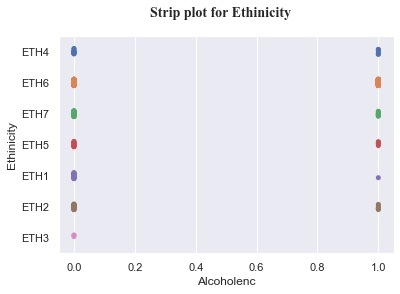

In [9]:
# Strip plot for Age
cat_var_list = ['Age', 'Gender', 'Education', 'Country', 'Ethinicity']
for cat_var in cat_var_list:
    plot_stripplot(data, cat_var)


### Heatmap for numeric data

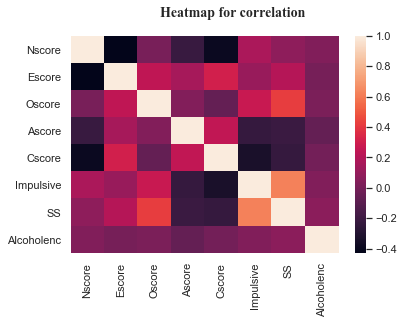

In [10]:
# Finding the correlation between the numeric attributes and target attribute
data_corr = data.corr()
sns.heatmap(data_corr, xticklabels=data_corr.columns,
            yticklabels=data_corr.columns)
plt.suptitle("Heatmap for correlation", fontsize=14,
             fontname="Times New Roman", fontweight="bold");


### RFE for numeric data

In [11]:
# Creating a temporary dataframe to hold only the numeric data
temp = data.drop(data.loc[:, 'Age':'Ethinicity'].columns, axis=1)
temp.drop(columns='Alcoholenc', inplace=True)
# Creating the feature and target vectors
X = temp.drop([column_name], axis=1).values
y = np.array(temp[column_name])
# Extracting the column names
column_names = temp.drop([column_name], axis=1).keys()
col_values = column_names.values

# Extracting the four best features by eliminating the ones that are not suitable for the dataset
# Building a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Setting up the RFE function to select the top 4 features
rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(X, y)
sel_features = fit.support_
rank_features = fit.ranking_
col_values = col_values[np.newaxis, :]
sel_features = sel_features[np.newaxis, :]
rank_features = rank_features[np.newaxis, :]
feature_selection_mat = np.concatenate(
    (col_values, sel_features, rank_features), axis=0)
feature_selection_mat.shape
df = pd.DataFrame(feature_selection_mat)
print("\033[1mThe list of feature ranking:\033[0m")
df.T


The list of feature ranking:


,0,1,2
0,Nscore,True,1
1,Escore,True,1
2,Oscore,True,1
3,Ascore,False,2
4,Cscore,True,1
5,Impulsive,False,4
6,SS,False,3


### Creating and analysing the final data set

In [12]:
# One hot encoding the selected categorical variable
ethinicity_encoded = OneHotEncoding(data, 'Ethinicity', 'Ethinicity')

# Creating a new dataframe to include the onehot encoded attributes
frame = [data, ethinicity_encoded]
final_set = pd.concat(frame, axis=1)

# Dropping the Ethinicity attribute as we now have the onehot encoded version
column_list = ['Age', 'Gender', 'Education', 'Country',
               'Ethinicity', 'Ascore', 'Impulsive', 'SS', 'Alcoholenc']
final_set = final_set.drop(column_list, axis=1)

# Renaming the target variable column name
final_set.rename(columns={'Alcohol': 'Used_Yesterday'}, inplace=True)

# Storing the target column name in a variable
column_name = 'Used_Yesterday'

# Converting the target attribute values into categorical data
final_set[column_name] = pd.Categorical(final_set[column_name])

# Printing the final dataset
print("\033[1mThe final data set:\033[0m")
final_set


The final data set:


,Nscore,Escore,Oscore,Cscore,Used_Yesterday,Ethinicity_ETH1,Ethinicity_ETH2,Ethinicity_ETH3,Ethinicity_ETH4,Ethinicity_ETH5,Ethinicity_ETH6,Ethinicity_ETH7
0,0.31287,-0.57545,-0.58331,-0.00665,N,0,0,0,1,0,0,0
1,-0.67825,1.93886,1.43533,-0.14277,N,0,0,0,0,0,1,0
2,-0.46725,0.80523,-0.84732,-1.01450,Y,0,0,0,0,0,1,0
3,-0.14882,-0.80615,-0.01928,0.58489,N,0,0,0,0,0,1,0
4,0.73545,-1.63340,-0.45174,1.30612,N,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-1.19430,1.74091,1.88511,-1.13788,N,0,0,0,0,0,1,0
1881,-0.24649,1.74091,0.58331,-1.51840,N,0,0,0,0,0,1,0
1882,1.13281,-1.37639,-1.27553,-1.38502,N,0,0,0,0,0,1,0
1883,0.91093,-1.92173,0.29338,-2.57309,N,0,0,0,0,0,1,0


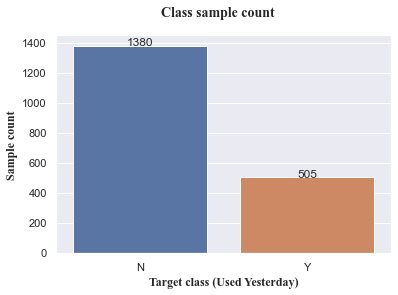

In [13]:
# Plotting the sample count in each class
ax = sns.countplot(final_set[column_name])
for rect in ax.patches:
    ax.annotate(rect.get_height(), (rect.get_x() +
                rect.get_width()/2, rect.get_height() + 0.75), ha='center')
plt.suptitle("Class sample count", fontsize=14,
             fontname="Times New Roman", fontweight="bold");
plt.xlabel('Target class (Used Yesterday)', fontsize=12,
           fontname="Times New Roman", fontweight="bold");
plt.ylabel('Sample count', fontsize=12,
           fontname="Times New Roman", fontweight="bold");


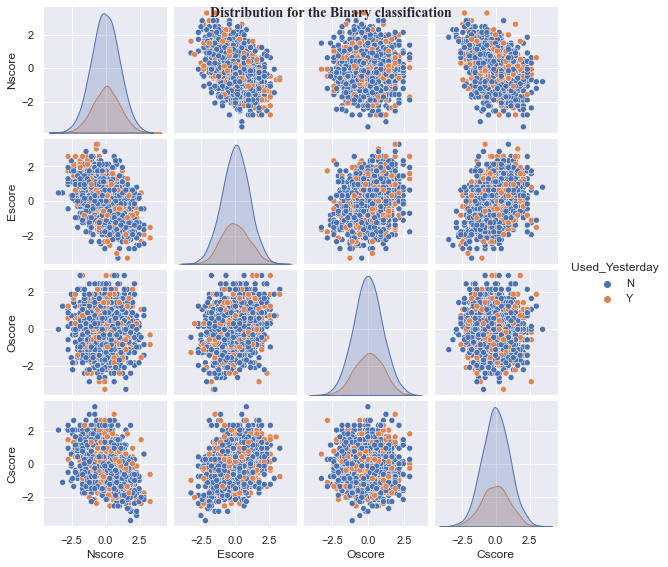

In [14]:
# Plotting the distribution for the binary classification
col_to_plot = final_set.columns[0:5].tolist()
sns.set()
sns.pairplot(final_set[col_to_plot], hue=column_name, height=2);
plt.suptitle("Distribution for the Binary classification",
             fontsize=14, fontname="Times New Roman", fontweight="bold");


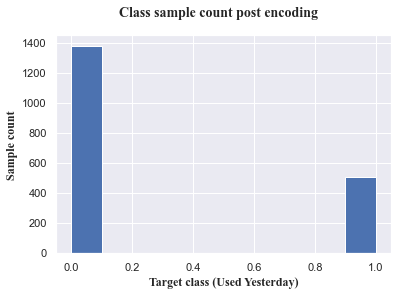

In [15]:
# Coverting the classes in the target attribute to '0' and '1'
vfunc = np.vectorize(fun)
final_set[column_name] = vfunc(final_set[column_name])

# Plotting a histogram for the target attribute post converting the classes to '0' and '1'
final_set[column_name].hist()
plt.suptitle("Class sample count post encoding", fontsize=14,
             fontname="Times New Roman", fontweight="bold");
plt.xlabel('Target class (Used Yesterday)', fontsize=12,
           fontname="Times New Roman", fontweight="bold");
plt.ylabel('Sample count', fontsize=12,
           fontname="Times New Roman", fontweight="bold");


## Searching for the best neural network

### Setting up the traning data

##### Spliting the data

In [16]:
# Splitting the dataset into training and testing data
datapoints = final_set.drop([column_name], axis=1).values
labels = np.array(final_set[column_name])
data_train, data_test, labels_train, labels_test = train_test_split(
    datapoints, labels, test_size=0.33, random_state=42, stratify=labels)


##### Setting up variables for future use

In [17]:
# Extracting the feature list
feature_list = list(final_set.columns)
feature_list.remove('Used_Yesterday')


In [18]:
# Finding the class weights for the majority and minority class
y_org = np.unique(labels_train)
class_weights = class_weight.compute_class_weight(
    'balanced', classes=y_org, y=labels_train)

# Converting the class_weights into dictionary format
class_weight_dict = dict(enumerate(class_weights))
print("\033[1mThe class weights:\033[0m")
print(class_weight_dict)

# Assigning the class weight dictionary to the class_weight parameter
class_weight = class_weight_dict


The class weights:
{0: 0.6829004329004329, 1: 1.8668639053254439}


##### Balancing the traning data based on the chose balancing technique

In [19]:
# Conditional logic to choose the technique to balance the samples
# Balancing data samples by oversampling the minority class using SMOTE technique
if (is_smote):
    smt = SMOTE(sampling_strategy=1)
    data_train_sm, labels_train_sm = smt.fit_resample(data_train, labels_train)
# Balancing data samples by oversampling the minority class using replication technique
elif (is_resampled):
    # Creating a dataframe for the training data
    df_training = pd.DataFrame(data_train)
    df_training[column_name] = labels_train
    # Segregating the data into classes
    df_classN = df_training[df_training[column_name] == 0]
    df_classY = df_training[df_training[column_name] == 1]

    # Resampling the minority class
    df_classY_resampled = resample(
        df_classY, random_state=42, n_samples=1380, replace=True)

    # Appending the majority and resampled minority classes
    df_training_resampled = df_classN.append(df_classY_resampled)

    # Splitting them into datapoints and labels
    data_train_rep = df_training_resampled.drop([column_name], axis=1).values
    labels_train_rep = np.array(df_training_resampled[column_name])


##### Version checks, seeding data and plot layout setup

In [20]:
# Python ≥3.5 is required
import tensorflow as tf
import sklearn
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
assert tf.__version__ >= "2.0"

# Seeding the data helps stabilize the current notebook's output stable across runs
np.random.seed(42)

# Setting up the parameters for plotting
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


##### Version checks, seeding data and plot layout setup

In [21]:
# Conditional logic to assign the appropriate train data to be used for building the NN
# Setting up the feature vector X and target vector y when balanced using SMOTE oversampling technique
if (is_smote):
    y = keras.utils.to_categorical(labels_train_sm)
    X = data_train_sm
# Setting up the feature vector X and target vector y when balanced using replication technique
elif (is_resampled):
    y = keras.utils.to_categorical(labels_train_rep)
    X = data_train_rep
# Setting up the feature vector X and target vector y when using the original imbalanced data
else:
    y = keras.utils.to_categorical(labels_train)
    X = data_train

# Splitting the train data into train and validation data
X_valid, X_train = X[:50], X[50:]
y_valid, y_train = y[:50], y[50:]

# Clear the backend to remove the clutter from the previous runs
keras.backend.clear_session()

# Seeding the data
np.random.seed(42)
tf.random.set_seed(42)


### Hyperparameter and network topology tuning

##### Finding the optimal optimizer and its corresponding learning rate and momentum

In [22]:
### Finding the best optimizer ###
# Create model
model_opt = KerasClassifier(
    build_fn=create_model_opt, epochs=300, batch_size=32, verbose=0)

# Defining the grid search parameters
optimizer = ['Adam', 'Adamax', 'Nadam','SGD', 'RMSprop', 'Adagrad', 'Adadelta']
param_grid_opt = dict(optimizer=optimizer)
grid_opt = GridSearchCV(
    estimator=model_opt, param_grid=param_grid_opt, n_jobs=-1, cv=3, scoring='precision')

# Conditional logic to choose the appropriate fit function parameters based on class weight balanc requirements
# Fit function when class weights should be balanced
if (is_class_balanced):
    grid_result_opt = grid_opt.fit(X_train, y_train, class_weight=class_weight)
# Fit function when class weights should not be balanced
else:
    grid_result_opt = grid_opt.fit(X_train, y_train)

# Extracting the best value(s)
best_optimizer = grid_result_opt.best_params_['optimizer']
print("Selected Optimizer: {}".format(best_optimizer))


###Finding the best learning rate and momentum ###
# Selecting the model creation function based on the optimizer and creating the model
if best_optimizer in ('SGD', 'RMSprop'):
    # define the grid search parameters
    learn_rate = [0.0001, 0.001, 0.005, 0.01]
    momentum = [0.1, 0.2, 0.3]
    param_grid = dict(learn_rate=learn_rate, momentum=momentum)
    if best_optimizer == 'SGD':
        model_lr = KerasClassifier(
            build_fn=create_model_SDG, epochs=300, batch_size=32, verbose=0)
    else:
        model_lr = KerasClassifier(
            build_fn=create_model_RMSprop, epochs=300, batch_size=32, verbose=0)
else:
    # Defining the grid search parameters
    learn_rate = [0.0001, 0.001, 0.005, 0.01]
    param_grid = dict(learn_rate=learn_rate)
    if best_optimizer == 'Adam':
        model_lr = KerasClassifier(
            build_fn=create_model_Adam, epochs=300, batch_size=32, verbose=0)
    elif best_optimizer == 'Adagrad':
        model_lr = KerasClassifier(
            build_fn=create_model_Adagrad, epochs=300, batch_size=32, verbose=0)
    elif best_optimizer == 'Adagrad':
        model_lr = KerasClassifier(
            build_fn=create_model_Adagrad, epochs=300, batch_size=32, verbose=0)
    elif best_optimizer == 'Adamax':
        model_lr = KerasClassifier(
            build_fn=create_model_Adamax, epochs=300, batch_size=32, verbose=0)
    elif best_optimizer == 'Nadam':
        model_lr = KerasClassifier(
            build_fn=create_model_Nadam, epochs=300, batch_size=32, verbose=0)

# Grid search
grid_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid,
                       n_jobs=-1, cv=3, scoring='precision')

# Conditional logic to choose the appropriate fit function parameters based on class weight balance requirements
# Fit function when class weights should be balanced
if (is_class_balanced):
    grid_result_lr = grid_lr.fit(X_train, y_train, class_weight=class_weight)
# Fit function when class weights should not be balanced
else:
    grid_result_lr = grid_lr.fit(X_train, y_train)

# Extracting the best value(s)
if best_optimizer in ('SGD', 'RMSprop'):
    best_lr = grid_result_lr.best_params_['learn_rate']
    best_mom = grid_result_lr.best_params_['momentum']
else:
    best_lr = grid_result_lr.best_params_['learn_rate']
    best_mom = 0

# Printing the best value(s)
printLRandMomentum(best_optimizer, best_lr, best_mom)


Selected Optimizer: Adam
Selected Learning rate: 0.0001


##### Finding the optimal neural network topology, initialization function and activation function

In [23]:
# Creating a model to find the best batch size and epoches
def create_model(hidden_layer=1, neurons_no=5, init_mode='uniform', activation='sigmoid', input_shape=[11]):
    # Create model
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(hidden_layer):
        model.add(keras.layers.Dense(
            neurons_no, kernel_initializer=init_mode, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(2, activation='softmax', **options))
    if best_optimizer in ('SGD', 'RMSProp'):
        optimizer = stringToClass(best_optimizer)(
            learning_rate=best_lr, momentum=best_mom)
    else:
        optimizer = Adam(learning_rate=best_lr)
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
    return model


model_tp = KerasClassifier(build_fn=create_model,
                           epochs=300, batch_size=32, verbose=0)


In [24]:
### Finding the best network topology values and initialization and activation functions ###
# Defining the grid search parameters
neurons_no = range(8,20,2)
hidden_layer = [4, 3, 2, 1]
# ['lecun_uniform','uniform', 'he_normal', 'he_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform']
init_mode = ['glorot_uniform', 'lecun_uniform', 'he_uniform']
# ['tanh','softsign', 'relu', 'sigmoid', 'softmax', 'softplus','hard_sigmoid', 'linear']
activation = ['tanh', 'relu', 'softsign']
param_grid = dict(neurons_no=neurons_no, hidden_layer=hidden_layer,
                  activation=activation, init_mode=init_mode)
grid_tp = GridSearchCV(estimator=model_tp, param_grid=param_grid,
                       n_jobs=-1, cv=3, scoring='precision')

# Conditional logic to choose the appropriate fit function parameters based on class weight balance requirements
# Fit function when class weights should be balanced
if (is_class_balanced):
    grid_result_tp = grid_tp.fit(X_train, y_train, class_weight=class_weight)
# Fit function when class weights should not be balanced
else:
    grid_result_tp = grid_tp.fit(X_train, y_train)

# Extracting the best value(s)
best_neurons_no = grid_result_tp.best_params_['neurons_no']
best_hidden_layers = grid_result_tp.best_params_['hidden_layer']
best_init_mode = grid_result_tp.best_params_['init_mode']
best_activation = grid_result_tp.best_params_['activation']

# Printing all the parameters
print("Selected Neurons: {}".format(best_neurons_no))
print("Selected Hidden layers: {}".format(best_hidden_layers))
print("Selected Weight Initialization: {}".format(best_init_mode))
print("Selected Activation function: {}".format(best_activation))


Selected Neurons: 8
Selected Hidden layers: 4
Selected Weight Initialization: glorot_uniform
Selected Activation function: tanh


##### Finding the optimal batch size and epochs

In [25]:
# Finding the best batch size and epochs
# Define the grid search parameters
batch_size = [32, 64]
epochs = [500, 550]
param_grid = dict(estimator__batch_size=batch_size, estimator__epochs=epochs)
grid_be = GridSearchCV(estimator=grid_result_tp,
                       param_grid=param_grid, n_jobs=-1, cv=3, scoring='precision')

# Conditional logic to choose the appropriate fit function parameters based on class weight balance requirements
# Fit function when class weights should be balanced
if (is_class_balanced):
    grid_result_be = grid_be.fit(X_train, y_train, class_weight=class_weight)
# Fit function when class weights should not be balanced
else:
    grid_result_be = grid_be.fit(X_train, y_train)

# Extracting the best value(s)
best_batch_size = grid_result_be.best_params_['estimator__batch_size']
best_epochs = grid_result_be.best_params_['estimator__epochs']
print("Selected Batch size: {}".format(best_batch_size))
print("Selected Epochs: {}".format(best_epochs))


Selected Batch size: 32
Selected Epochs: 500


## The optimal neural network

### Building and training the neural network with the obtained optimal hyperparameters

##### Building the neural network

In [26]:
# Printing all the hyperparameters
print("Selected Optimizer: {}".format(best_optimizer))
printLRandMomentum(best_optimizer, best_lr, best_mom)
print("Selected Neurons: {}".format(best_neurons_no))
print("Selected Hidden layers: {}".format(best_hidden_layers))
print("Selected Weight Initialization: {}".format(best_init_mode))
print("Selected Activation function: {}".format(best_activation))
print("Selected Batch size: {}".format(best_batch_size))
print("Selected Epochs: {}".format(best_epochs))


Selected Optimizer: Adam
Selected Learning rate: 0.0001
Selected Neurons: 8
Selected Hidden layers: 4
Selected Weight Initialization: glorot_uniform
Selected Activation function: tanh
Selected Batch size: 32
Selected Epochs: 500


In [27]:
# Creating the final model
model = keras.models.Sequential()
model.add(keras.layers.Dense(8, input_dim=len(feature_list),
          kernel_initializer=best_init_mode, activation=best_activation))
model.add(keras.layers.Dense(7, activation=best_activation))
model.add(keras.layers.Dense(6, activation=best_activation))
model.add(keras.layers.Dense(5, activation=best_activation))
# Do not update this statement
model.add(keras.layers.Dense(2, activation='softmax'))
if best_optimizer in ('SGD', 'RMSProp'):
    optimizer = stringToClass(best_optimizer)(
        learning_rate=best_lr, momentum=best_mom)
else:
    optimizer = stringToClass(best_optimizer)(learning_rate=best_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=[tf.keras.metrics.Precision()])


##### Training the neural network and capturing the training time

In [28]:
%%time
# Conditional logic to choose the appropriate model to run parameters based on class weight balance requirements
# Fit function when class weights should be balanced
if (is_class_balanced):
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=best_epochs, batch_size=best_batch_size, verbose=1)
# Fit function when class weights should not be balanced
else:
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=best_epochs, batch_size=best_batch_size, verbose=1, class_weight=class_weight)


Epoch 1/500
38/38 [==============================] - 0s 5ms/step - loss: 0.7198 - precision_4: 0.5355 - val_loss: 0.7114 - val_precision_4: 0.4800
Epoch 2/500
38/38 [==============================] - 0s 1ms/step - loss: 0.7167 - precision_4: 0.5289 - val_loss: 0.7119 - val_precision_4: 0.4800
Epoch 3/500
38/38 [==============================] - 0s 1ms/step - loss: 0.7142 - precision_4: 0.5297 - val_loss: 0.7102 - val_precision_4: 0.4800
Epoch 4/500
38/38 [==============================] - 0s 1ms/step - loss: 0.7119 - precision_4: 0.5256 - val_loss: 0.7100 - val_precision_4: 0.4800
Epoch 5/500
38/38 [==============================] - 0s 2ms/step - loss: 0.7100 - precision_4: 0.5223 - val_loss: 0.7095 - val_precision_4: 0.5000
Epoch 6/500
38/38 [==============================] - 0s 1ms/step - loss: 0.7084 - precision_4: 0.5190 - val_loss: 0.7085 - val_precision_4: 0.5000
Epoch 7/500
38/38 [==============================] - 0s 2ms/step - loss: 0.7070 - precision_4: 0.5132 - val_loss: 0.70

38/38 [==============================] - 0s 2ms/step - loss: 0.6893 - precision_4: 0.5223 - val_loss: 0.6825 - val_precision_4: 0.5600
Epoch 112/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6892 - precision_4: 0.5140 - val_loss: 0.6830 - val_precision_4: 0.5400
Epoch 113/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6891 - precision_4: 0.5198 - val_loss: 0.6823 - val_precision_4: 0.5600
Epoch 114/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6890 - precision_4: 0.5132 - val_loss: 0.6834 - val_precision_4: 0.5400
Epoch 115/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6890 - precision_4: 0.5124 - val_loss: 0.6832 - val_precision_4: 0.5400
Epoch 116/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6889 - precision_4: 0.5124 - val_loss: 0.6826 - val_precision_4: 0.5400
Epoch 117/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6889 - precision_4: 0.5124 - val_loss: 0.68

38/38 [==============================] - 0s 2ms/step - loss: 0.6866 - precision_4: 0.5099 - val_loss: 0.6801 - val_precision_4: 0.5800
Epoch 167/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6864 - precision_4: 0.5223 - val_loss: 0.6791 - val_precision_4: 0.5600
Epoch 168/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6864 - precision_4: 0.5272 - val_loss: 0.6788 - val_precision_4: 0.5600
Epoch 169/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6864 - precision_4: 0.5314 - val_loss: 0.6779 - val_precision_4: 0.5600
Epoch 170/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6863 - precision_4: 0.5182 - val_loss: 0.6803 - val_precision_4: 0.5400
Epoch 171/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6863 - precision_4: 0.5165 - val_loss: 0.6791 - val_precision_4: 0.5600
Epoch 172/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6862 - precision_4: 0.5281 - val_loss: 0.67

38/38 [==============================] - 0s 2ms/step - loss: 0.6839 - precision_4: 0.4959 - val_loss: 0.6761 - val_precision_4: 0.5600
Epoch 222/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6836 - precision_4: 0.5050 - val_loss: 0.6749 - val_precision_4: 0.5800
Epoch 223/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6837 - precision_4: 0.5272 - val_loss: 0.6742 - val_precision_4: 0.5800
Epoch 224/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6837 - precision_4: 0.5289 - val_loss: 0.6735 - val_precision_4: 0.5800
Epoch 225/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6835 - precision_4: 0.5272 - val_loss: 0.6743 - val_precision_4: 0.6000
Epoch 226/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6835 - precision_4: 0.5281 - val_loss: 0.6739 - val_precision_4: 0.6000
Epoch 227/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6834 - precision_4: 0.5157 - val_loss: 0.67

38/38 [==============================] - 0s 2ms/step - loss: 0.6809 - precision_4: 0.5107 - val_loss: 0.6714 - val_precision_4: 0.6200
Epoch 277/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6810 - precision_4: 0.5380 - val_loss: 0.6698 - val_precision_4: 0.6200
Epoch 278/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6808 - precision_4: 0.5322 - val_loss: 0.6696 - val_precision_4: 0.6000
Epoch 279/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6807 - precision_4: 0.5330 - val_loss: 0.6697 - val_precision_4: 0.6000
Epoch 280/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6811 - precision_4: 0.4967 - val_loss: 0.6730 - val_precision_4: 0.6400
Epoch 281/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6807 - precision_4: 0.5198 - val_loss: 0.6697 - val_precision_4: 0.6000
Epoch 282/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6806 - precision_4: 0.5347 - val_loss: 0.66

38/38 [==============================] - 0s 2ms/step - loss: 0.6780 - precision_4: 0.5264 - val_loss: 0.6672 - val_precision_4: 0.6400
Epoch 332/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6779 - precision_4: 0.5248 - val_loss: 0.6661 - val_precision_4: 0.6400
Epoch 333/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6779 - precision_4: 0.5305 - val_loss: 0.6667 - val_precision_4: 0.6400
Epoch 334/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6778 - precision_4: 0.5322 - val_loss: 0.6665 - val_precision_4: 0.6400
Epoch 335/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6778 - precision_4: 0.5396 - val_loss: 0.6655 - val_precision_4: 0.6400
Epoch 336/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6777 - precision_4: 0.5446 - val_loss: 0.6656 - val_precision_4: 0.6400
Epoch 337/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6776 - precision_4: 0.5305 - val_loss: 0.66

38/38 [==============================] - 0s 1ms/step - loss: 0.6753 - precision_4: 0.5363 - val_loss: 0.6647 - val_precision_4: 0.6400
Epoch 387/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6752 - precision_4: 0.5429 - val_loss: 0.6628 - val_precision_4: 0.6600
Epoch 388/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6752 - precision_4: 0.5454 - val_loss: 0.6638 - val_precision_4: 0.6400
Epoch 389/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6753 - precision_4: 0.5528 - val_loss: 0.6626 - val_precision_4: 0.6600
Epoch 390/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6751 - precision_4: 0.5479 - val_loss: 0.6641 - val_precision_4: 0.6400
Epoch 391/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6750 - precision_4: 0.5446 - val_loss: 0.6632 - val_precision_4: 0.6600
Epoch 392/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6751 - precision_4: 0.5503 - val_loss: 0.66

38/38 [==============================] - 0s 997us/step - loss: 0.6728 - precision_4: 0.5512 - val_loss: 0.6613 - val_precision_4: 0.6200
Epoch 442/500
38/38 [==============================] - 0s 990us/step - loss: 0.6729 - precision_4: 0.5578 - val_loss: 0.6598 - val_precision_4: 0.6200
Epoch 443/500
38/38 [==============================] - 0s 960us/step - loss: 0.6727 - precision_4: 0.5536 - val_loss: 0.6624 - val_precision_4: 0.6200
Epoch 444/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6726 - precision_4: 0.5561 - val_loss: 0.6620 - val_precision_4: 0.6400
Epoch 445/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6727 - precision_4: 0.5528 - val_loss: 0.6622 - val_precision_4: 0.6200
Epoch 446/500
38/38 [==============================] - 0s 976us/step - loss: 0.6726 - precision_4: 0.5396 - val_loss: 0.6625 - val_precision_4: 0.6200
Epoch 447/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6726 - precision_4: 0.5512 - val_lo

Epoch 496/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6705 - precision_4: 0.5413 - val_loss: 0.6620 - val_precision_4: 0.6000
Epoch 497/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6705 - precision_4: 0.5561 - val_loss: 0.6605 - val_precision_4: 0.6000
Epoch 498/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6705 - precision_4: 0.5578 - val_loss: 0.6608 - val_precision_4: 0.6000
Epoch 499/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6705 - precision_4: 0.5487 - val_loss: 0.6608 - val_precision_4: 0.6000
Epoch 500/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6705 - precision_4: 0.5528 - val_loss: 0.6609 - val_precision_4: 0.6000
Wall time: 35.7 s


### Summarizing the model's history using graphs

##### Summarizing for precision

In [29]:
# Extracting the metrics stored in history
dict_keys = history.history.keys()
history_keys = list()
for i in history.history.keys():
    history_keys.append(i)

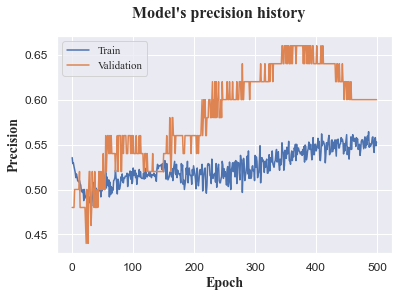

In [30]:
# Plotting the history for precision
plt.plot(history.history[history_keys[1]])
plt.plot(history.history[history_keys[3]])
plt.suptitle("Model's precision history", fontsize=16, fontname="Times New Roman", fontweight="bold");
plt.xlabel('Epoch', fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.ylabel('Precision', fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.legend(['Train', 'Validation'], loc='upper left',prop={'family': 'Times New Roman'});
plt.show()


##### Summarizing for loss

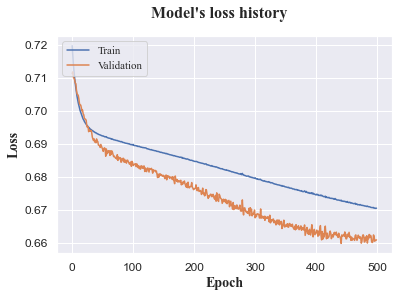

In [31]:
# Plotting the history for loss
plt.plot(history.history[history_keys[0]])
plt.plot(history.history[history_keys[2]])
plt.suptitle("Model's loss history", fontsize=16, fontname="Times New Roman", fontweight="bold");
plt.xlabel('Epoch', fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.ylabel('Loss', fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.legend(['Train', 'Validation'], loc='upper left', prop={'family': 'Times New Roman'});
plt.show()


### Evaluating the model

##### Setting up test data and model evaluation

In [32]:
# Setting the feature and target vectors for test data
X_testing = data_test
y_testing = keras.utils.to_categorical(labels_test)

# Evaluating the model
model.evaluate(X_testing, y_testing, verbose=1)


20/20 [==============================] - 0s 783us/step - loss: 0.6861 - precision_4: 0.4960


[0.6861047148704529, 0.4959871470928192]

##### Resultant model metrics

Accuracies:
Training Accuracy: 0.5536303630363036
Testing Accuracy: 0.4959871589085072
Classification report:
              precision    recall  f1-score   support

           0      0.487     0.735     0.586       302
           1      0.521     0.271     0.357       321

    accuracy                          0.496       623
   macro avg      0.504     0.503     0.471       623
weighted avg      0.504     0.496     0.468       623



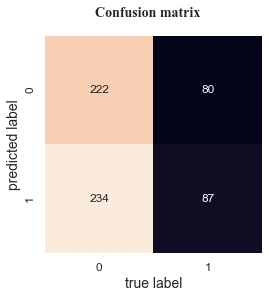

In [33]:
# Predicting the labels using test data
y_testing_pred = model.predict(X_testing)
# Converting the 2-D predict output to 1-D to pass as an argument to the metric generation fucntions
y_testing_pred_bool = np.argmax(y_testing_pred, axis=1)

# Predicting the labels using train data
y_train_pred = model.predict(X_train)
# Converting the 2-D predict output to 1-D to pass as an argument to the metric generation fucntions
y_train_pred_bool = np.argmax(y_train_pred, axis=1)
y_train_bool = np.argmax(y_train, axis=1)

# Model Accuracy
print("\033[1mAccuracies:\033[0m")
print("Training Accuracy:", accuracy_score(y_train_bool, y_train_pred_bool))
print("Testing Accuracy:", accuracy_score(labels_test, y_testing_pred_bool))

# Model classification report
print("\033[1mClassification report:\033[0m")
print(classification_report(y_testing_pred_bool, labels_test, digits=3))

# Building the confusion matrix for test data
confusion = confusion_matrix(y_testing_pred_bool, labels_test)
# Plotting a Heatmap for the confusion matrix
sns.heatmap(confusion, square=True, annot=True, fmt='d', cbar=False)
plt.suptitle("Confusion matrix", fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.xlabel('true label')
plt.ylabel('predicted label');


## Machine Learning technique - SVM

In [34]:
# Define pipeline for combining the SMOTE balancing technique with the SVM ML
svmbdo = SVC(gamma=0.01, C=300, degree=3,
             kernel='poly', class_weight='balanced')
steps = [('over', SMOTE(sampling_strategy=0.8)), ('model', svmbdo)]
pipeline_svmbdo = Pipeline(steps=steps)


##### Training the SVM model and capturing the training time

In [35]:
%%time
pipeline_svmbdo.fit(data_train, labels_train)


Wall time: 112 ms


Pipeline(steps=[('over', SMOTE(sampling_strategy=0.8)),
                ('model',
                 SVC(C=300, class_weight='balanced', gamma=0.01,
                     kernel='poly'))])

##### Resultant model metrics

Training Accuracy: 0.5071315372424723
Testing Accuracy: 0.4751203852327448
              precision    recall  f1-score   support

           0      0.441     0.736     0.551       273
           1      0.569     0.271     0.368       350

    accuracy                          0.475       623
   macro avg      0.505     0.504     0.459       623
weighted avg      0.513     0.475     0.448       623



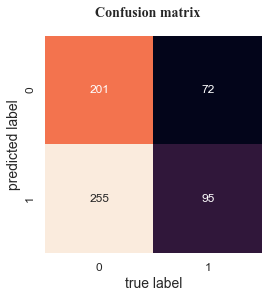

In [36]:
# Predicting the values using the trained model
data_test_pred = pipeline_svmbdo.predict(data_test)
data_train_pred = pipeline_svmbdo.predict(data_train)

# Model Accuracy
print("Training Accuracy:", accuracy_score(labels_train, data_train_pred))
print("Testing Accuracy:", accuracy_score(labels_test, data_test_pred))

# Model Precision
print(classification_report(data_test_pred, labels_test, digits=3))

# Confusion Matrix
mat = confusion_matrix(labels_test, data_test_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=pipeline_svmbdo.classes_, yticklabels=pipeline_svmbdo.classes_)
plt.suptitle("Confusion matrix", fontsize=14, fontname="Times New Roman", fontweight="bold");
plt.xlabel('true label');
plt.ylabel('predicted label');


## Plotting the metrics and training times for SVM and NN

#### <span style="color:blue">Replace the numeric values in the dataframe below to generate plots</span>

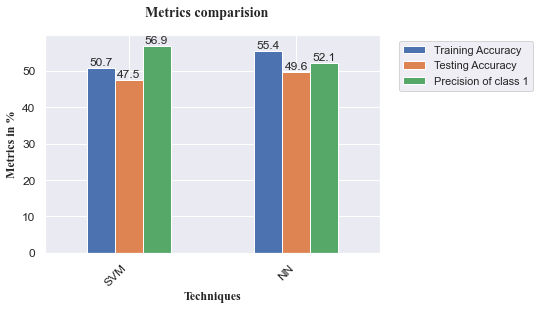

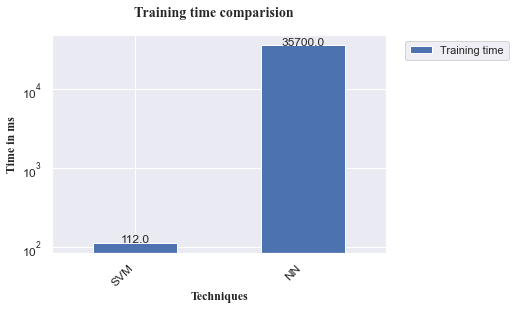

In [37]:
# Dataframe containing the metrics
"""
Update the values as ['SVM', <Training accuracy for SVM>, <Testing Accuracy for SVM>, <Precision of class 1 for SVM>] 
and ['NN', <Training accuracy for NN>, <Testing Accuracy for NN>, <Precision of class 1 for NN>] 
"""
df = pd.DataFrame([['SVM', 50.7, 47.5, 56.9], ['NN', 55.4, 49.6, 52.1]],
                  columns=['Technique', 'Training Accuracy', 'Testing Accuracy', 'Precision of class 1'])

# Dataframe containing the training times
"""
Update the values as ['SVM', <Training time for SVM>] and ['NN', <Training time for NN>] 
"""
df1 = pd.DataFrame([['SVM', 112], ['NN', 35700]],
                   columns=['Technique', 'Training time'])

# Plotting a graph for the metrics
ax = df.plot(x='Technique', kind='bar', stacked=False)
plt.xlabel('Techniques', fontsize=12, fontname="Times New Roman", fontweight="bold");
plt.ylabel('Metrics in %', fontsize=12, fontname="Times New Roman", fontweight="bold")
plt.suptitle("Metrics comparision", fontsize=14, fontname="Times New Roman", fontweight="bold");
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
for rect in ax.patches:
    ax.annotate("%.1f" % rect.get_height(), (rect.get_x() +
                rect.get_width()/2, rect.get_height() + 0.75), ha='center')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

# Plotting a graph for the training times
ax = df1.plot(x='Technique', kind='bar', stacked=False)
plt.xlabel('Techniques', fontsize=12, fontname="Times New Roman", fontweight="bold");
plt.ylabel('Time in ms', fontsize=12, fontname="Times New Roman", fontweight="bold");
plt.suptitle("Training time comparision", fontsize=14, fontname="Times New Roman", fontweight="bold");
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set(yscale='log')
for rect in ax.patches:
    ax.annotate("%.1f" % rect.get_height(), (rect.get_x() +
                rect.get_width()/2, rect.get_height() + 0.75), ha='center')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
